<a href="https://colab.research.google.com/github/arjunks95/healthcare-ml/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading data to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/chest_xray

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!ls

###Unzip

###Visualise the images

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from tensorflow.keras.metrics import categorical_accuracy
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
import os

In [ ]:
import cv2

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/')
print(mainDIR)

['.DS_Store', 'test', 'train', 'val']


In [ ]:
train_folder= '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train/'
val_folder = '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/val/'
test_folder = '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test/'

In [ ]:
# train 
os.listdir(train_folder)
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

No of normal images in train  1342
normal picture title:  IM-0239-0001.jpeg
No of pneumonia images in train  3876
pneumonia picture title: person465_virus_957.jpeg


Text(0.5, 1.0, 'Pneumonia')

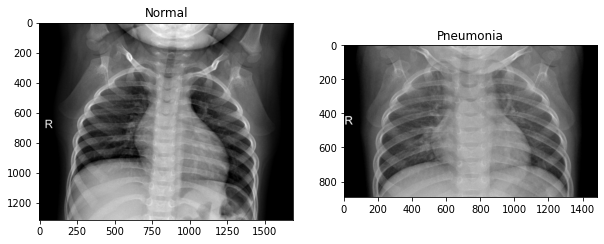

In [ ]:
#Normal pic 
print('No of normal images in train ',len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))
print('No of pneumonia images in train ',len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)
'''
# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)
'''
#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
normal_img =  cv2.imread(norm_pic_address)
plt.imshow(normal_img)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
p_img =  cv2.imread(sic_address)
plt.imshow(p_img)
#img_plot = plt.imshow(sic_load,cmap='gray')
a2.set_title('Pneumonia')




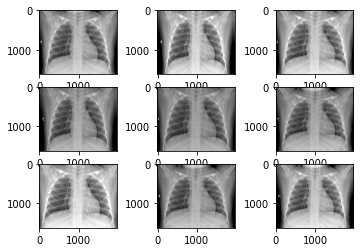

In [ ]:
# Trial of Image data generator since the number of normal images were lesser
from tensorflow.keras.preprocessing.image import load_img,img_to_array
img = load_img(norm_pic_address)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
#datagen = ImageDataGenerator(brightness_range=[0.7,1.3])
datagen = ImageDataGenerator(
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        #vertical_flip=True
        zoom_range = 0.1, # Randomly zoom image 
        brightness_range=[0.8,1.2])
        #shear_range=0.2)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        #vertical_flip=True)  # randomly flip images
# prepare iterator
it = datagen.flow(samples, batch_size=1)


for i in range(9):
	plt.subplot(330+i+1)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show() 

In [ ]:


list = os.listdir('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train/NORMAL') # dir is your directory path
number_files = len(list)
print(number_files)

1342


####Model Build

In [ ]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)
                                   #horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train',
                                                 target_size = (200, 200),
                                                 batch_size = 32,
                                                 class_mode = 'binary',shuffle=True)

validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/val',
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary',shuffle=True)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test',
                                            target_size = (200, 200),
                                            batch_size = 8,
                                            class_mode = 'binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:

cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(200, 200, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

#3rd Convolution
cnn.add(Conv2D(32,(3,3),activation='relu'))

#3rd Pooling Layer
cnn.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#callback monitoring validation accuracy and reducing Learning rate by a factor of 0.1 upon reaching plateau, to prevent
# overfitting 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=2, min_lr=0.001)


In [ ]:
# OLD
gen = ImageDataGenerator()
'''gent = ImageDataGenerator(zoom_range = 0.2, # Upon several iterations of Datagenerator for training set
        width_shift_range=0.1,                 # due to data imbalance, there was constant overfitting 
        height_shift_range=0.1)'''             # The val accuracy did not increase hence, it was omitted, instead L2 regularisation was done
train_batches = gen.flow_from_directory("/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/train",target_size=(200,200),color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=32)
valid_batches = gen.flow_from_directory("/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/val",target_size=(200,200),color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test",target_size=(200,200), shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history=cnn.fit(training_set,validation_data=validation_set,callbacks=[reduce_lr],epochs=15)

Epoch 1/15
163/163 [==============================] - 2334s 14s/step - loss: 0.4505 - accuracy: 0.7906 - val_loss: 0.8372 - val_accuracy: 0.6250
Epoch 2/15
163/163 [==============================] - 88s 541ms/step - loss: 0.2311 - accuracy: 0.9085 - val_loss: 0.5427 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - 89s 546ms/step - loss: 0.1972 - accuracy: 0.9252 - val_loss: 0.6295 - val_accuracy: 0.6250
Epoch 4/15
163/163 [==============================] - 89s 544ms/step - loss: 0.1657 - accuracy: 0.9344 - val_loss: 0.2093 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 88s 543ms/step - loss: 0.1484 - accuracy: 0.9429 - val_loss: 0.6342 - val_accuracy: 0.6875
Epoch 6/15
163/163 [==============================] - 89s 548ms/step - loss: 0.1474 - accuracy: 0.9467 - val_loss: 0.4273 - val_accuracy: 0.8125
Epoch 7/15
163/163 [==============================] - 89s 543ms/step - loss: 0.1412 - accuracy: 0.9468 - val_loss: 0.6479 - val_ac

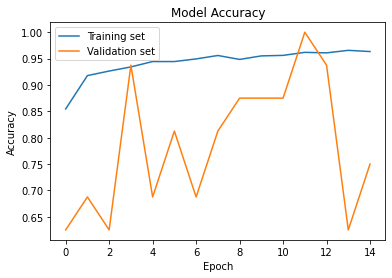

In [ ]:
# The variation of training accuracy vs validation set accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

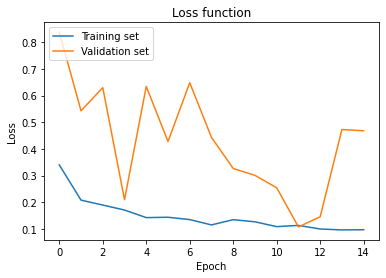

In [ ]:
# Validation loss vs Training loss
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
test_accu = cnn.evaluate(test_set)
#Test set reports an accuracy of 86.22%

78/78 [==============================] - 253s 3s/step - loss: 0.5143 - accuracy: 0.8830


In [ ]:
p = cnn.predict(test_set, verbose=True)

78/78 [==============================] - 6s 73ms/step


In [ ]:
#Creating a DF of the softmax probability output 
pre3 = pd.DataFrame(p)
pre3["filename"] = test_set.filenames
pre3["label"] = (pre3["filename"].str.contains("PNEUMONIA")).apply(int)# Generating actual labels based on filename
pre3["pre"] = (pre3[0]>0.5).apply(int) # giving a value of one where softmax function has returned probability >0.5

In [ ]:
pre3
np.argmax(pre3[0])

246

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


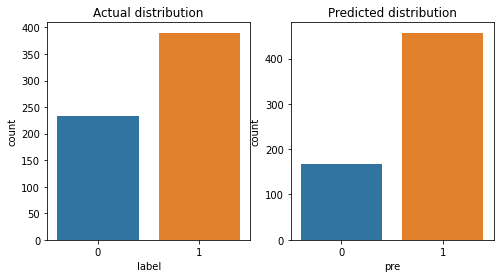

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.countplot(pre3['label'])
plt.title('Actual distribution')
plt.subplot(1,2,2)
sns.countplot(pre3['pre'],)
plt.title('Predicted distribution')
plt.show()

In [ ]:
recall_score(pre3["label"],pre3["pre"])

0.9923076923076923

In [ ]:
roc_auc_score(pre3["label"],pre3[0])


0.9532160859083936

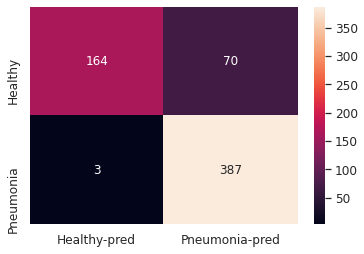

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(pre3["label"],pre3["pre"])
df_cm = pd.DataFrame(cm, ['Healthy','Pneumonia'],['Healthy-pred','Pneumonia-pred'])
sns.set(font_scale=1.1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g')
plt.show()

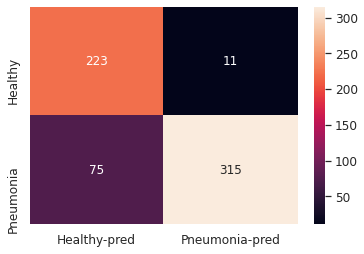

In [ ]:
from sklearn.metrics import confusion_matrix ##Old model built has more False Negatives hence neglected
import seaborn as sns
cm=confusion_matrix(pre3["label"],pre3["pre"])
df_cm = pd.DataFrame(cm, ['Healthy','Pneumonia'],['Healthy-pred','Pneumonia-pred'])
sns.set(font_scale=1.1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g')
plt.show()

In [ ]:
accuracy_score(pre3["label"],pre3["pre"])

0.8830128205128205

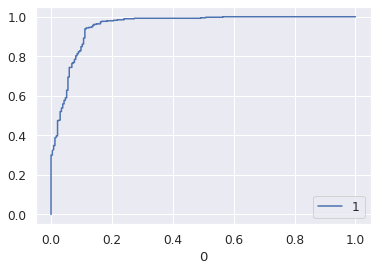

In [ ]:
tpr,fpr,thres = roc_curve(pre3["label"],pre3[0])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)


In [ ]:
from sklearn.metrics import f1_score
print("The F1 score for the final model on test set is {:.2f}".format(f1_score(pre3["label"],pre3["pre"])*100))

The F1 score for the final model on test set is 91.38


In [ ]:
pre3['pre'].value_counts()

1    326
0    298
Name: pre, dtype: int64

In [ ]:
pre3['label'].value_counts()

1    390
0    234
Name: label, dtype: int64

In [ ]:
cnn.save('/content/drive/MyDrive/updatedfinal_CNN.h5')

This final chosen model has an optimal test accuracy of 86.2 and an AUC score of 96.2 and a decent F1 score of 87.99

####Previous model- Only for reference

In [ ]:
# Had uneven Dropout rates across model, without L2 regularisation,no callback, 
#training batch size of 16 and input size of (64,64)
model2.fit_generator(train_batches,validation_data=valid_batches,epochs=3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
326/326 [==============================] - 2436s 7s/step - loss: 0.4595 - accuracy: 0.8728 - val_loss: 0.8662 - val_accuracy: 0.6250
Epoch 2/3
326/326 [==============================] - 49s 150ms/step - loss: 0.1390 - accuracy: 0.9491 - val_loss: 0.2791 - val_accuracy: 0.8750
Epoch 3/3
326/326 [==============================] - 49s 151ms/step - loss: 0.1216 - accuracy: 0.9519 - val_loss: 0.3605 - val_accuracy: 0.8750


In [ ]:
model2.save('/content/drive/MyDrive/my_model2.h5')

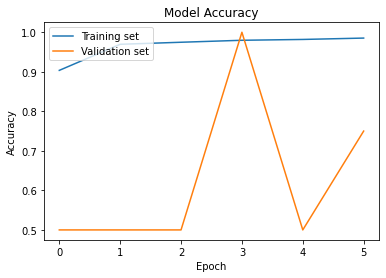

In [ ]:
# Accuracy 
plt.plot(model2.history.history["accuracy"])
plt.plot(model2.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

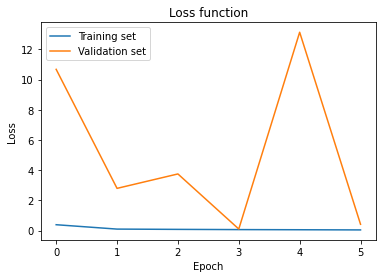

In [ ]:
# Accuracy 
plt.plot(model2.history.history["loss"])
plt.plot(model2.history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
p = model2.predict(test_batches, verbose=True)

78/78 [==============================] - 5s 63ms/step


In [ ]:
test_accu = model2.evaluate(test_batches)

78/78 [==============================] - 5s 64ms/step - loss: 1.7885 - accuracy: 0.7003


In [ ]:
#p = model.predict_generator(test_batches, verbose=True)
pre2 = pd.DataFrame(p)
pre2["filename"] = test_batches.filenames
pre2["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre2['pre'] = (pre[1]>0.5).apply(int)

In [ ]:
pre2['pre'].value_counts()

1    506
0    118
Name: pre, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


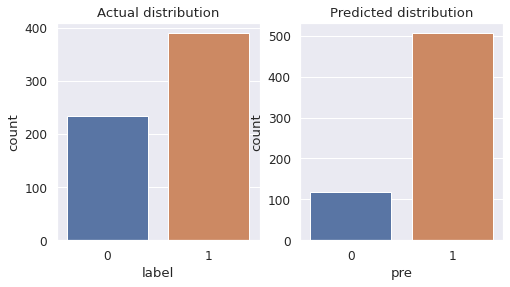

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.countplot(pre2['label'])
plt.title('Actual distribution')
plt.subplot(1,2,2)
sns.countplot(pre2['pre'],)
plt.title('Predicted distribution')
plt.show()

In [ ]:
pre2['label'].value_counts()

1    390
0    234
Name: label, dtype: int64

In [ ]:
recall_score(pre["label"],pre["pre"])

0.9717948717948718

In [ ]:
roc_auc_score(pre["label"],pre[1])


0.8678446197676967

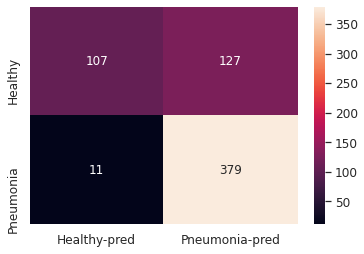

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(pre2["label"],pre2["pre"])
df_cm = pd.DataFrame(cm, ['Healthy','Pneumonia'],['Healthy-pred','Pneumonia-pred'])
sns.set(font_scale=1.1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='g')
plt.show()

Many False positives but very less false negatives, if the focus is more on reducing false negatives then this model could be considered however, to avoid build up of antibiotic resitance and preventing mutations it is good to reduce the no of false positives too, specificity needs to be higher hence the previous model is preferred

In [ ]:
accuracy_score(pre2["label"],pre2["pre"])

0.7788461538461539

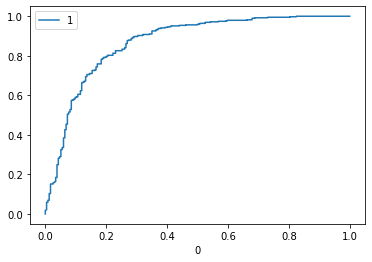

In [ ]:
tpr,fpr,thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)


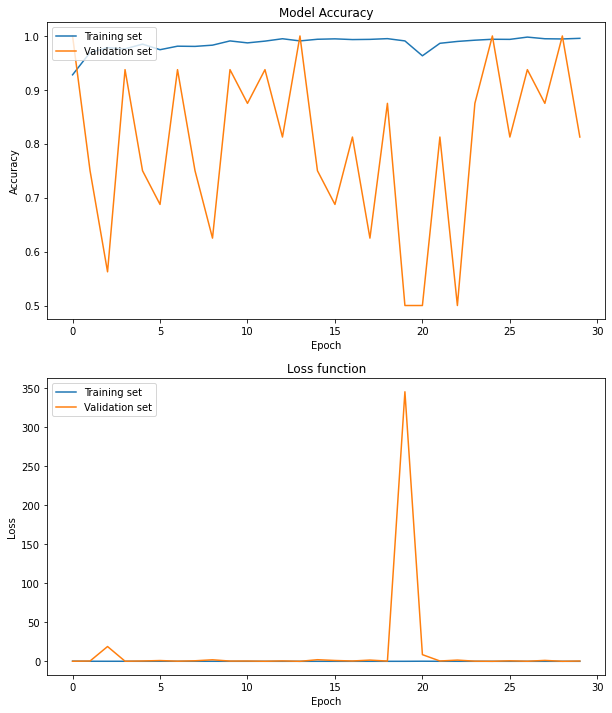

In [ ]:
# The variation of training accuracy vs validation set accuracy For the 30 epoch trial
#Test set accuracy of 69.7

plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

# Validation loss vs Training loss
plt.subplot(2,1,2)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

####References
https://www.mayoclinic.org/diseases-conditions/pneumonia/multimedia/chest-x-ray-showing-pneumonia/img-20005827

https://keras.io/api/models/model_training_apis/
https://www.coursera.org/specializations/ai-for-medicine
https://www.kaggle.com/michalbrezk/x-ray-pneumonia-cnn-tensorflow-2-0-keras-94

https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia
https://www.kaggle.com/alifrahman/pneumonia-detection-with-cnn-auc-score-0-94
	https://www.kaggle.com/cosmosankur/cnn-keras-for-by-beginner
https://www.kaggle.com/aayushmishra1512/pneumonia-detection-using-cnn
Data:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#### Deploy

In [ ]:
pred[0][0]

0.99758804

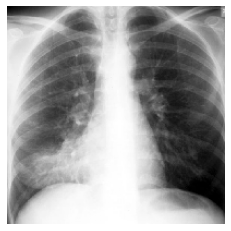

array([[0.99758804]], dtype=float32)

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(200, 200))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


#if __name__ == "__main__":

    # load model
model = load_model('/content/drive/MyDrive/updatedfinal_CNN.h5')

    # image path
#img_path = '/content/IM-0001-0001.jpeg'    # unknown
#img_path = '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg'      # test-pne
#img_path= '/content/drive/MyDrive/Kaggle/chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg'
#img_path= '/content/cdf5605e45874c28262c81b7ab80b3_gallery.jpeg'
img_path='/content/ch4946.fig1_.jpg'
    # load a single image
new_image = load_image(img_path,show=True)


    # check prediction
pred = model.predict(new_image)
pred

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/updatedfinal_CNN.h5')
  return model
with st.spinner('Loading Model into memory soon..... '):
  model=load_model()

st.write("""
          # Chest X-Ray classifier
          """
          )

file= st.file_uploader("Please upload the Chest X-Ray image", type=["jpeg","jpg","png"])
import cv2
from PIL import Image, ImageOps
import numpy as np

def import_and_predict(image_data,model):
  size=(200,200)
  image=ImageOps.fit(image_data,size,Image.ANTIALIAS)
  img=np.asarray(image)
  image_reshape=img[np.newaxis,...]
  prediction=model.predict(image_reshape)
  return prediction

if file is None:
  st.text("Please upload a valid image")
else:
  image=Image.open(file)
  st.image(image,use_column_width=True)
  predictions= import_and_predict(image,model)
  class_names=['Normal','Pneumonia']

  if prediction[0]<=0.5:
    st.success('I am {:2f}% sure that this image can be diagnosed as Normal'.format(predictions[0]))
  else:
    st.success('I am {:2f}% sure that this image can be diagnosed to be having Pneumonia'.format(predictions[1]))
               
          


In [ ]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-5.0.1-cp36-none-any.whl size=18822 sha256=827efa6d0e709a7bdfe7dc90faec34f979e14b5b2f6345087fbb2f84e374762c
  Stored in directory: /root/.cache/pip/wheels/94/01/05/d39efb8f6b40a411354b4168ca9dda99e6f8d586e458e97551
Successfully built pyngrok


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

!mkdir -p /drive
#umount /drive
!mount --bind /content/drive/My\ Drive /drive
!mkdir -p /drive/ngrok-ssh
!mkdir -p ~/.ssh

In [ ]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2021-01-19 10:45:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.234.81.220, 35.175.47.233, 3.213.223.141, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.234.81.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  35.6MB/s    in 0.4s    

2021-01-19 10:45:31 (35.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip


In [ ]:
!./ngrok authtoken 1mnWreL6UMNl39fbgPdVSFZnNi0_2ankkaeQFrxpFmYd9xRkb

/bin/bash: ./ngrok: Permission denied


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok
url = ngrok.connect(port=8501)
url

t=2021-01-19T10:45:51+0000 lvl=warn msg="failed to start tunnel" pg=/api/tunnels id=2197da123dad1bb2 err="Your account may not run more than 2 tunnels over a single ngrok client session.\nThe tunnels already running on this session are:\n[]\n\r\n\r\nERR_NGROK_324\r\n"


PyngrokNgrokHTTPError: ignored

In [ ]:
!streamlit run --server.port 80 /content/app.py

2021-01-19 10:46:01.042758: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:80
  External URL: http://35.245.160.170:80

2021-01-19 10:46:02.430735: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-19 10:46:02.431685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-19 10:46:02.436099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-19 10:46:02.436405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemo

In [ ]:
!cat nohup.out

2021-01-08 18:28:31.253143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.221.13.29:8501

2021-01-08 18:28:32.912304: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-08 18:28:32.913507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-08 18:28:32.974864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-08 18:28:32.975466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMe